# Выбор моделей

 В данном ноутбуке представлен процесс предобработки выбранных ранее данных.
 
 #### 1. Загрузка данных
 Сперва имортируем нужны библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics

from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import LinearSVR

from sklearn.ensemble import VotingRegressor

Затем загрузим непосредственно наш набор данных и посмотрим на его корреляционную матрицу

In [2]:
df = pd.read_csv('table_all.csv')

drop_list = ['Регион','Качество жизни']
target = 'Качество жизни'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 38 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Регион                                                                                   85 non-null     object 
 1   Процент людей вовлеченных в бизнес                                                       85 non-null     float64
 2   Общий оборот компании                                                                    85 non-null     float64
 3   Всего взяток                                                                             85 non-null     int64  
 4   Ввп                                                                                      85 non-null     float64
 5   Продолжительность жизни                                           

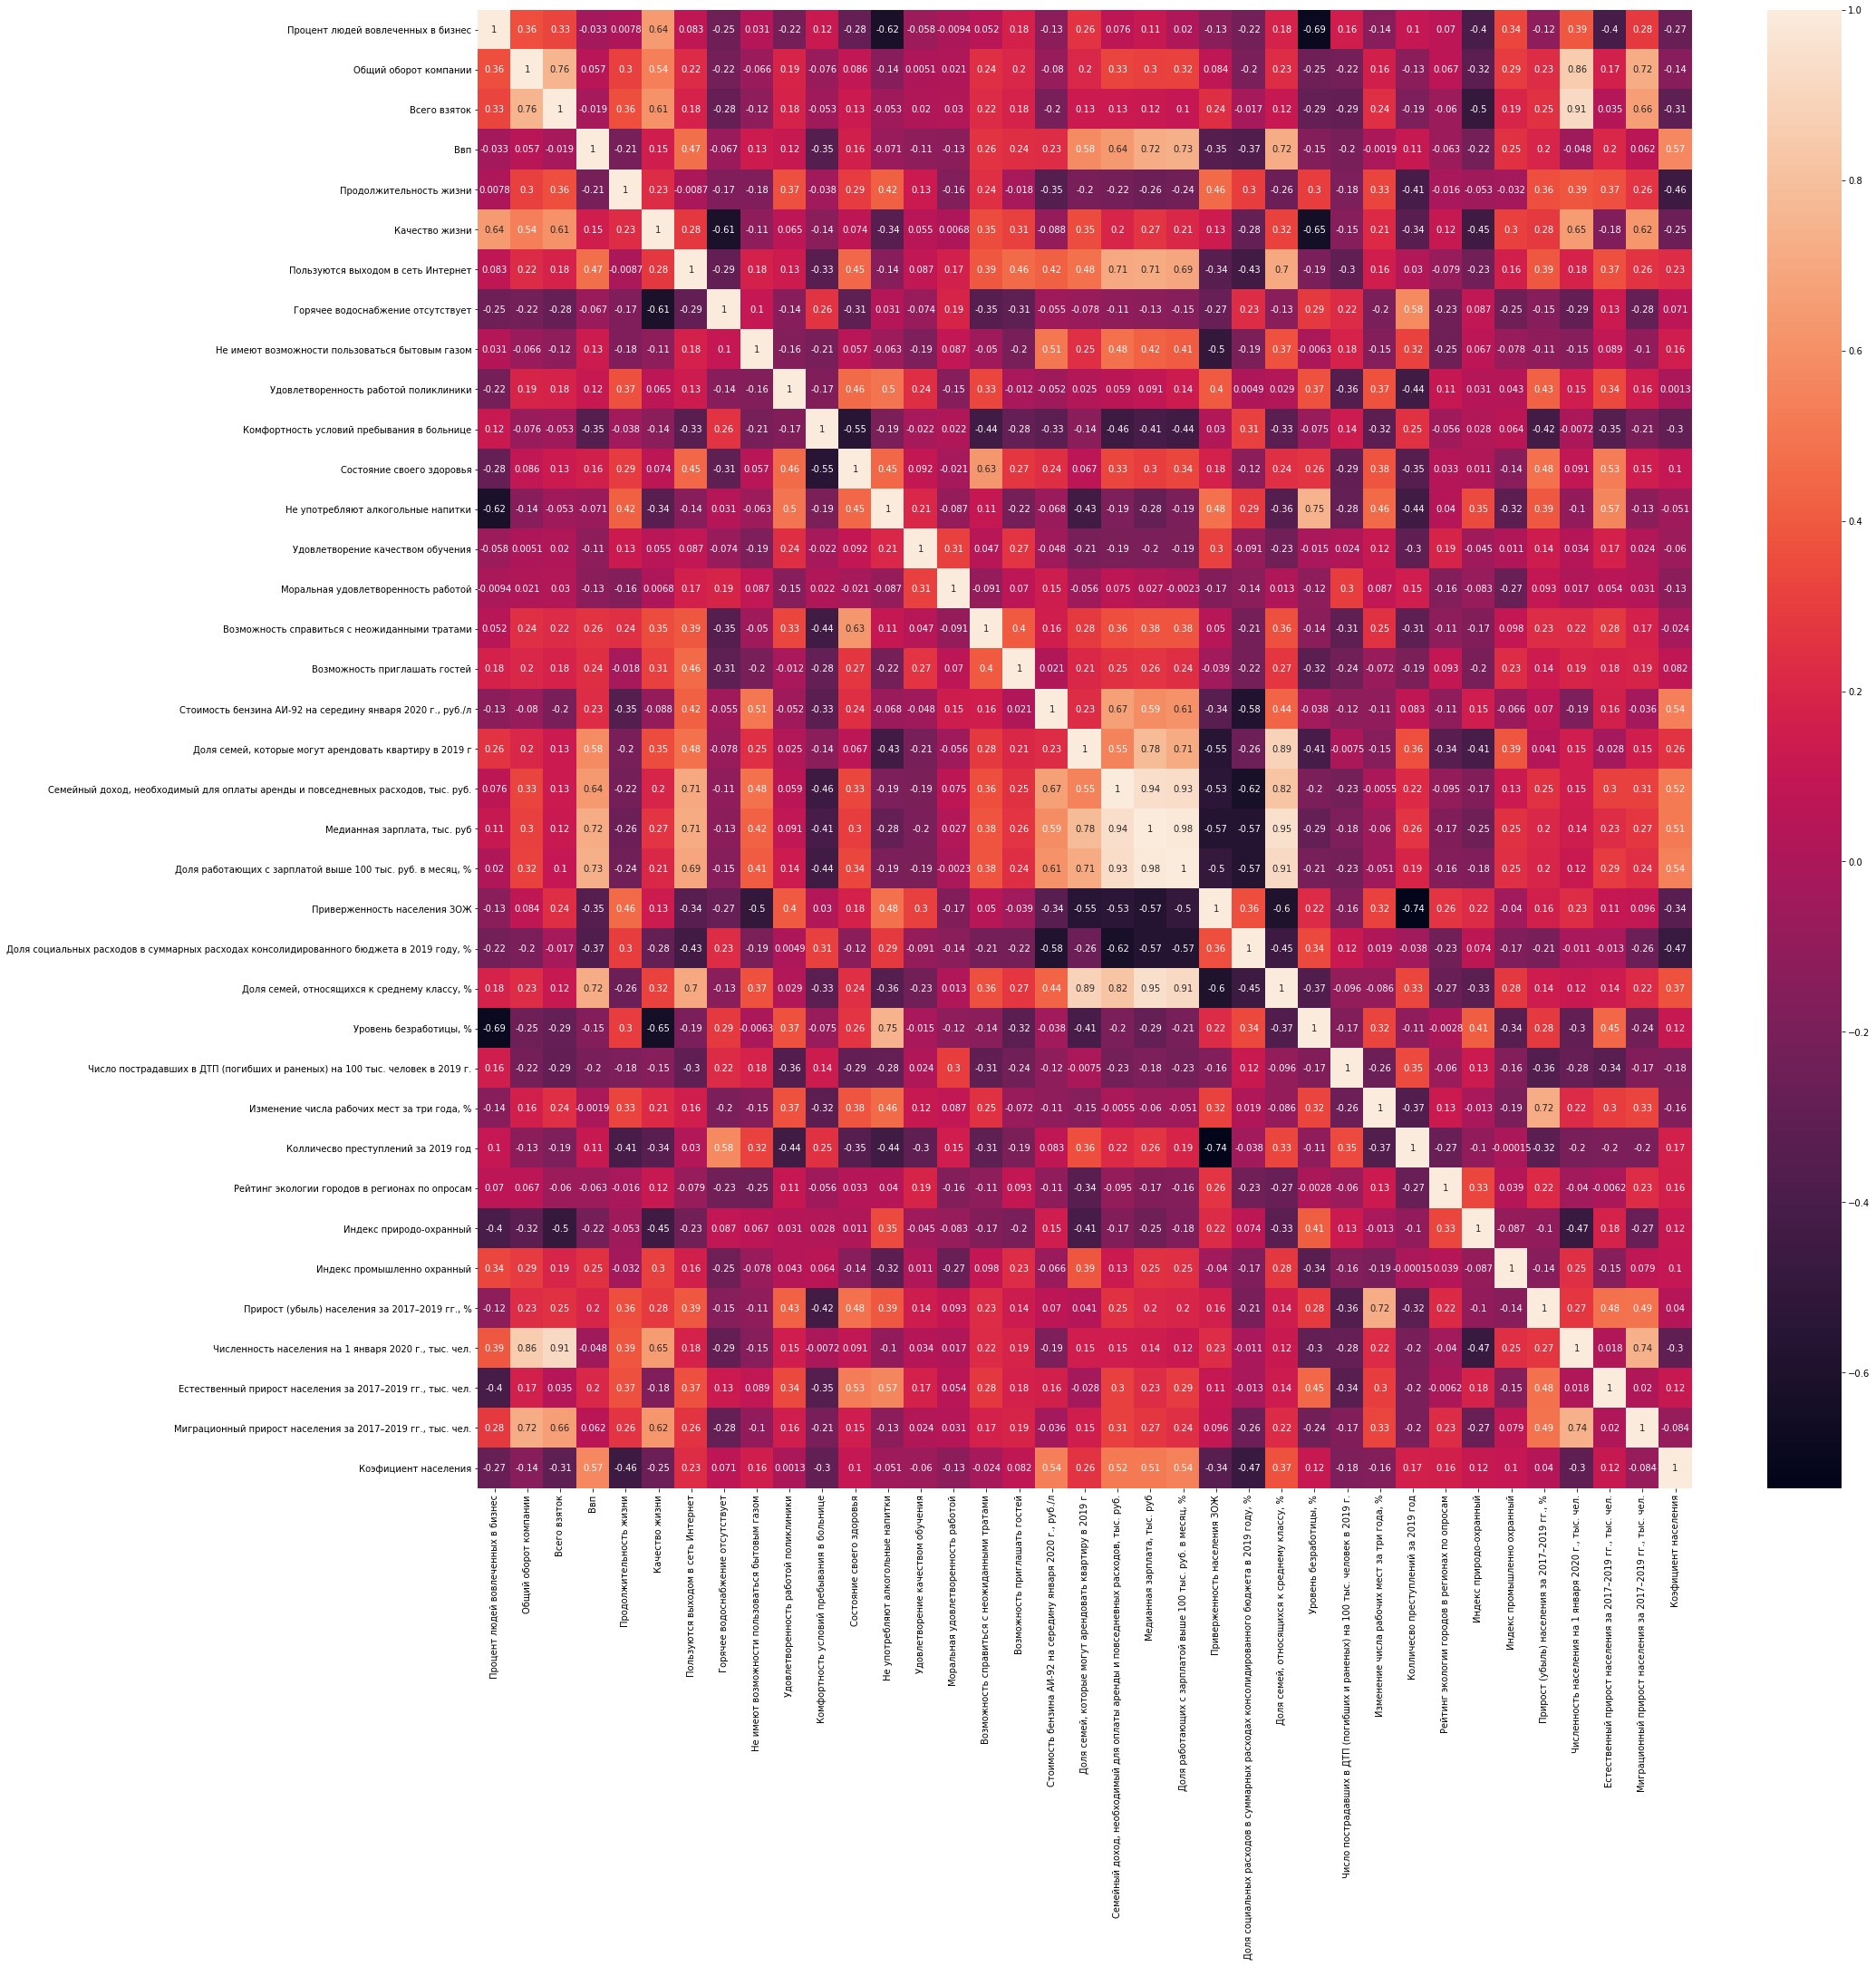

In [3]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True);

   Как мы видим несколько признаков явно корелируют друг с другом.
Для того что бы не вводить линейные алгоритмы в замешательство удалим несколько признаков с явной кореляцией и еще раз посмотрим на матрицу.

In [4]:
df = df.copy(deep = True).drop(['Ввп', 'Доля работающих с зарплатой выше 100 тыс. руб. в месяц, %',
              'Семейный доход, необходимый для оплаты аренды и повседневных расходов, тыс. руб.',
              'Численность населения на 1 января 2020 г., тыс. чел.', 'Коэфициент населения',
              'Доля семей, которые могут арендовать квартиру в 2019 г', 'Всего взяток',
              'Миграционный прирост населения за 2017–2019 гг., тыс. чел.',
              'Естественный прирост населения за 2017–2019 гг., тыс. чел.',
              'Общий оборот компании', 'Доля семей, относящихся к среднему классу, %',], axis = 1)

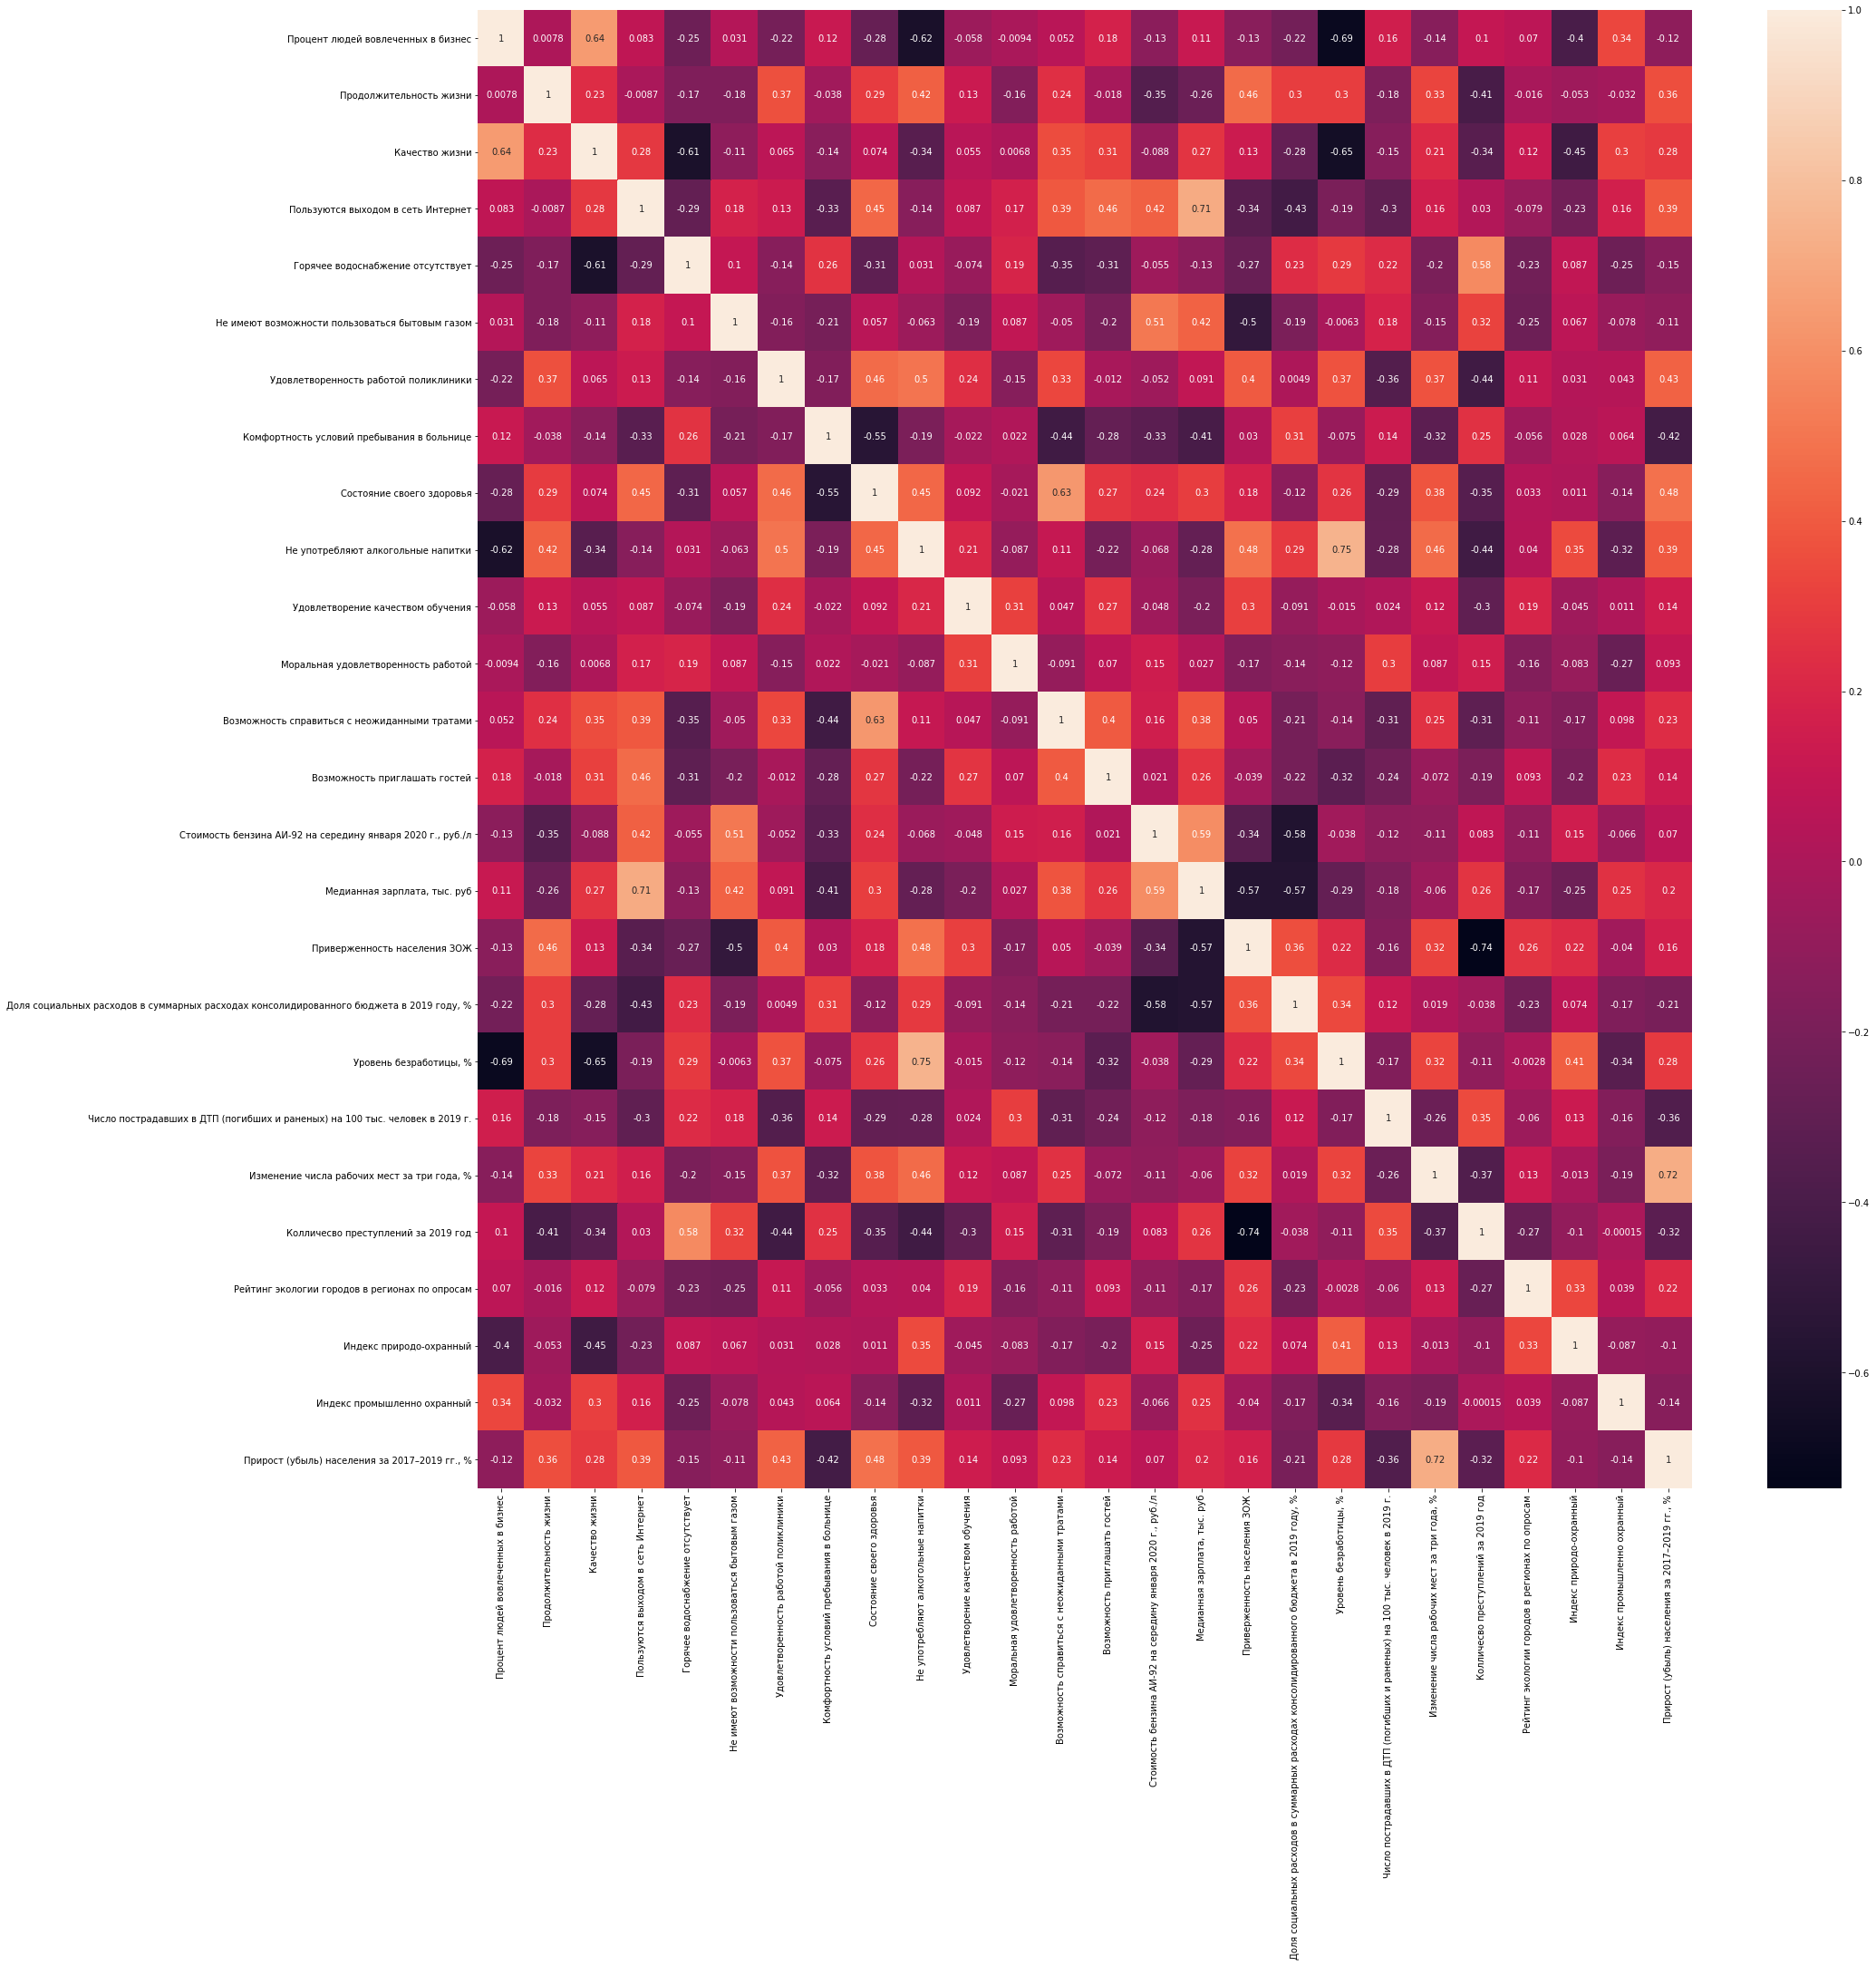

In [5]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True);

#### 2. Предобработка данных
Далее займемся очисткой данных, заменой пропусков разбиением на тестовую и тренировочную выборки и шкалированием.


In [6]:
list_nan = ['Не имеют возможности пользоваться бытовым газом', 'Комфортность условий пребывания в больнице',
            'Горячее водоснабжение отсутствует']

for name in list_nan:
    df[name] = df[name].apply(lambda x: x if x > 0 else df[name].mean())

x_train,x_test,y_train,y_test = train_test_split(df.drop(drop_list,axis = 1),
                                                 df[target],
                                                 random_state = 22,
                                                 test_size = 0.25)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Далее напишем небольшие функции для удобного отображения метрик качества взятых алгоритмов

In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

measured_metrics = pd.DataFrame({'Type_metrics':["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index('Type_metrics', inplace=True )

def print_metrics(y_test,y_pred,type_metric):
    metric_error = [
        metrics.mean_absolute_error(y_test, y_pred),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        metrics.r2_score(y_test, y_pred),
        mean_absolute_percentage_error(y_test, y_pred)
    ]
    measured_metrics[type_metric] = metric_error
    print(measured_metrics)


#### 3. Применение алгоритмов

   Теперь используем алгоритм простой линейной регресии на полученный набор данных, запишем его метрики качества и посмотрим на важность признаков при его построении

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled,y_train)
y_predict = lin_reg.predict(x_test_scaled)
print_metrics(y_test,y_predict,'LinearRegression')

              LinearRegression
Type_metrics                  
MAE                   3.931571
RMSE                  4.546355
R2                    0.864175
MAPE                  9.428268


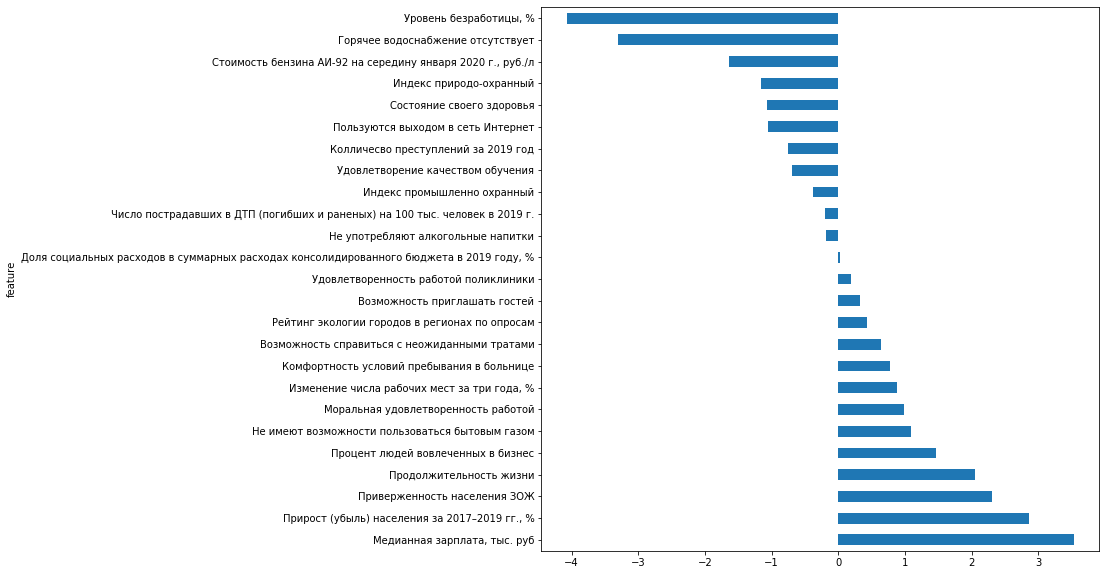

In [9]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':lin_reg.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

Постренный алгоритм простой линейной регресии дает уже неплохие результаты. Но стоит попробовать и другие методы, воспользуемся деревом решений, а затем переберем его вариации для улучшения результатов и так же оценим вклад признаков в предсказание модели

In [10]:
tree_common = DecisionTreeRegressor()
tree_common.fit(x_train_scaled,y_train)
y_predict_common = tree_common.predict(x_test_scaled)
print_metrics(y_test,y_predict_common,'DecisionTree')

              LinearRegression  DecisionTree
Type_metrics                                
MAE                   3.931571      7.991364
RMSE                  4.546355      9.492193
R2                    0.864175      0.407911
MAPE                  9.428268     21.001978


In [11]:
tree_parametrs = {
    'max_depth' : list(range(1,29)),
    'min_samples_leaf' : list(range(5,29)),
}

tree_cv = GridSearchCV(DecisionTreeRegressor(), tree_parametrs,n_jobs=-1, scoring = 'neg_mean_squared_error')
tree_cv.fit(x_train_scaled,y_train)

y_pred_cv = tree_cv.predict(x_test_scaled)
print_metrics(y_test,y_pred_cv,'GS-CVTree')

              LinearRegression  DecisionTree  GS-CVTree
Type_metrics                                           
MAE                   3.931571      7.991364   5.944706
RMSE                  4.546355      9.492193   7.320198
R2                    0.864175      0.407911   0.647873
MAPE                  9.428268     21.001978  14.782310


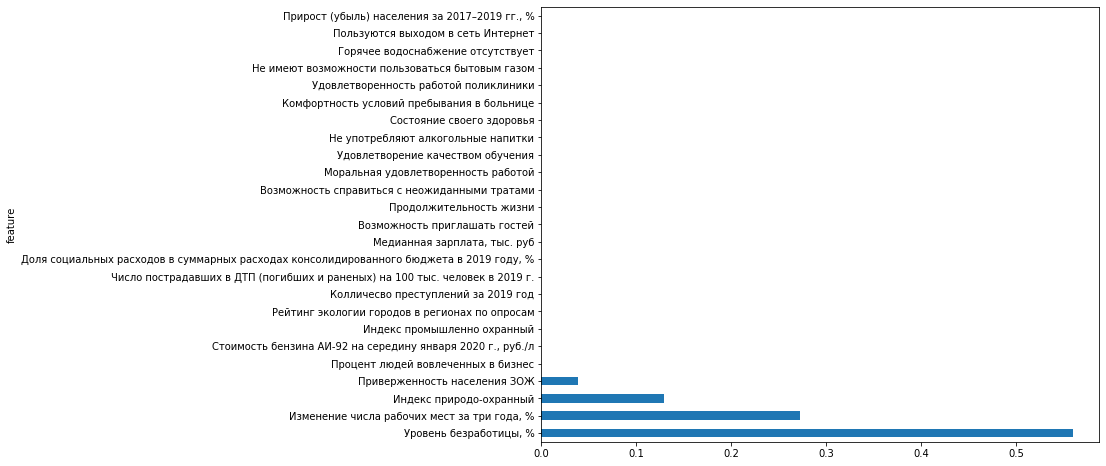

In [12]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':tree_cv.best_estimator_.feature_importances_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,8))

В целом дерево решений хуже справляется с задачей, построим предсказание индекса счастья с помощью метода опорных векторов.

In [13]:
svr = LinearSVR()
svr.fit(x_train_scaled,y_train)
y_predict = svr.predict(x_test_scaled)
print_metrics(y_test,y_predict,'SVM')

              LinearRegression  DecisionTree  GS-CVTree        SVM
Type_metrics                                                      
MAE                   3.931571      7.991364   5.944706   6.037647
RMSE                  4.546355      9.492193   7.320198   7.230485
R2                    0.864175      0.407911   0.647873   0.656451
MAPE                  9.428268     21.001978  14.782310  14.217114


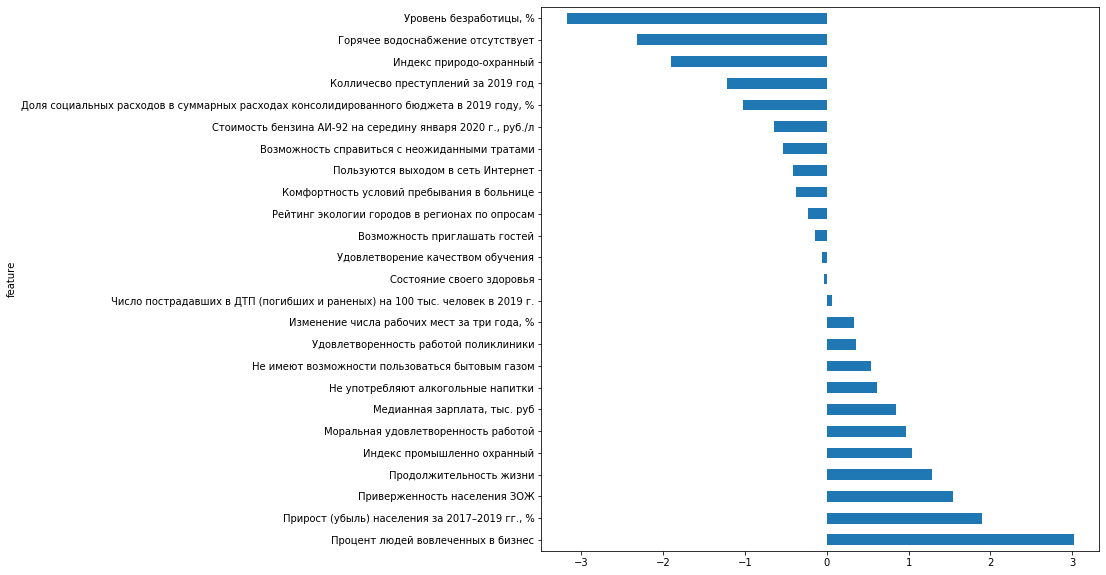

In [14]:
feature = pd.DataFrame({'feature':df.drop(drop_list,axis = 1).columns,'importence':svr.coef_})
feature.set_index('feature', inplace = True)
feature.sort_values('importence',ascending = False, inplace = True)
feature['importence'].plot(kind = 'barh', figsize = (10,10))

И наконец объединим этим методы в VotingRegressor (для DecisionTreeRegressor будем использовать лучшие подобранные параметры) и посмотрим на конечный список полученных метрик всех алгоритмов.

In [15]:
tree_cv.best_estimator_.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(max_depth=16, min_samples_leaf=11)>

In [16]:
voting = VotingRegressor(estimators = [('lr',lin_reg), ('svm',svr), ('tc',DecisionTreeRegressor(max_depth=9, min_samples_leaf=12))])
voting.fit(x_train_scaled,y_train)
y_predict_voiting = voting.predict(x_test_scaled)
print_metrics(y_test, y_predict_voiting,'Voiting')

              LinearRegression  DecisionTree  GS-CVTree        SVM   Voiting
Type_metrics                                                                
MAE                   3.931571      7.991364   5.944706   6.037647  3.692171
RMSE                  4.546355      9.492193   7.320198   7.230485  5.008482
R2                    0.864175      0.407911   0.647873   0.656451  0.835159
MAPE                  9.428268     21.001978  14.782310  14.217114  8.531222


#### 4. Заключение

Как можно увидеть в таблицей алгоритмом с наименьшей ошибкой является "голосующий" ансамбль из всех представленнх алгоритмов выше, однако отобразить важность вклада каждого из признаков при таком подходе не представляется возможным, поэтому для дальнейших исследований был выбран алгоритм линейной регресси.